In [1]:
import numpy as np
import lightkurve as lk

from astroquery.mast import Catalogs

from leo_vetter.stellar import quadratic_ldc
from leo_vetter.main import TCELightCurve
from leo_vetter.plots import plot_modshift, plot_summary
from leo_vetter.thresholds import check_thresholds

### Vetting example for TOI-101.01

In this example, we will compute metrics for TOI-101.01 (the known planet WASP-46 b). The vetter is meant to run on post-planet-search results, so we'll assume we already know the orbital period, transit epoch (time of first transit), and transit duration.

First let's get a light curve for the target (TIC-231663901).

In [2]:
tic = 231663901 # star TIC ID
per = 1.430363  # orbital period in days
epo = 1338.885  # time of first transit in TESS BJD
dur = 0.069     # transit duration in days

# Download all SPOC FFI light curves
search_result = lk.search_lightcurve(f"TIC {tic}", mission="TESS", author="TESS-SPOC")
lcs = search_result.download_all()

# Stitch light curves together into a multi-sector light curve
lc = lcs.stitch()

# Remove NaNs and poor quality cadences
lc = lc[~np.isnan(lc["flux"]) & (lc["quality"] == 0)]

# Flatten the light curve
# Highly recommend that the transits are masked out when flattening the light curve
transit_mask = lc.create_transit_mask(transit_time=epo, period=per, duration=dur)
lc_flat = lc.flatten(mask=transit_mask)

# Extract the relevant arrays
time = np.asarray(lc_flat["time"].value)
raw = np.asarray(lc["flux"].value)
flux = np.asarray(lc_flat["flux"].value)
flux_err = np.asarray(lc_flat["flux_err"].value)

We also need to know some basic stellar properties, which will be important for deriving parameters like the planet radius and orbital semi-major axis later, as well as limb-darkening parameters to use in transit model fits.

In [3]:
result = Catalogs.query_criteria(catalog="TIC", ID=tic)
star = {}
star["tic"] = tic
for key in ["rad","mass","rho","Teff","logg"]:
    star[key] = float(result[key])
    star["e_"+key] = float(result["e_"+key])

# Get limb-darkening parameters from Teff and logg
star["u1"], star["u2"] = quadratic_ldc(star["Teff"], star["logg"])

star

{'tic': 231663901,
 'rad': 0.890774,
 'e_rad': 0.0438467,
 'mass': 1.05,
 'e_mass': 0.129454,
 'rho': 1.48555,
 'e_rho': 0.316251,
 'Teff': 5824.0,
 'e_Teff': 135.304,
 'logg': 4.55972,
 'e_logg': 0.0757679,
 'u1': 0.3075,
 'u2': 0.2743}

Load the light curve and signal properties into the TCELightCurve class (TCE stands for Threshold Crossing Event, which is our possible planet signal). Since this is the first TCE found in the light curve, we'll assign it a `planetno` (planet number) of 1.

In [4]:
tlc = TCELightCurve(tic, time, raw, flux, flux_err, per, epo, dur, planetno=1)

The `tlc` object already contains values that will be used to compute metrics. This is not an exhaustive list, but here are some particularly useful ones:
- `tlc.phase`: the light curve phase-folded on the TCE period, covering orbital phase between -0.5 and 0.5 with the transit centred at 0.
- `tlc.in_tran`: a mask indicating in-transit cadences (i.e. cadences within 0.5 transit durations of the transit centre).
- `tlc.near_tran`: a mask indicating near-transit cadences (i.e. cadences within 1 transit duration of the transit centre).
- `tlc.fit_tran`: a mask indicating transit cadences that will be used when fitting models (i.e. cadences within 2 transit durations of the transit centre).
- `tlc.odd_tran`: a mask indicating in-transit cadences corresponding to odd transits.
- `tlc.even_tran`: a mask indicating odd-transit cadences corresponding to even transits.
- `tlc.N_transit`: the number of transits in the light curve. This does not include transits landing in gaps (i.e. transits without in-transit cadences).
- `tlc.n_in`: the number of in-transit cadences.
- `tlc.dep`: the transit depth.
- `tlc.qtran`: the transit duration divided by the orbital period.

Now let's compute all the metrics:

In [5]:
tlc.compute_flux_metrics(star, verbose=True)

# Save results to a file. The default filename is "(tic).(planetno).metrics", but you
# can give this function any desired filename as an input. 
tlc.save_metrics()

Estimating SES and MES time series...


/Users/mkuni/.local/lib/python3.9/site-packages/leo_vetter/utils.py:17: RuntimeWarning: invalid value encountered in double_scalars
  mean = np.sum(w * y) / np.sum(w)
/Users/mkuni/.local/lib/python3.9/site-packages/leo_vetter/utils.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  err = 1 / np.sqrt(np.sum(w))


Fitting linear, trapezoid, and transit models...
Running SWEET test...
Getting odd-even metrics...
Checking individual transit events...
Running modshift...
Estimating derived parameters...
Done!


/Users/mkuni/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/mkuni/.local/lib/python3.9/site-packages/leo_vetter/individual.py:70: RuntimeWarning: divide by zero encountered in double_scalars
  tlc.redchi2[i] = chi2 / (np.sum(fit_epoch) - 6)


The vetter then needs to compare the metrics against a series of pass-fail thresholds, which determine whether or not a signal is consistent with a planet candidate (PC), false alarm (FA; noise and instrumental systematics, stellar variability), or false positive (FP; eclipsing binaries, nearby eclipsing systems). Something that passes all tests is a PC, and something that fails any test is an FA/FP.

Note: instead of giving it the `tlc.metrics` dictionary, `check_thresholds` can also take a pandas dataframe containing a large number of metric results as an input. This would make it easier to automatically vet multiple signals at once.

In [6]:
FA = check_thresholds(tlc.metrics, "FA", verbose=True) # FA is True if any tests failed; False otherwise
FP = check_thresholds(tlc.metrics, "FP", verbose=True) # FP is True if any tests failed; False otherwise

if not FA and not FP:
    print(f"TIC-{tlc.tic}.{tlc.planetno} is a planet candidate!")

Passed all FA tests
Passed all FP tests
TIC-231663901.1 is a planet candidate!


Finally, it can be useful to visually confirm whether or not the signal is consistent with a planet using vetting reports. 

The first type of vetting report included in the package is an attempt to replicate the "modshift" plots from Jeff Coughlin's Model-Shift Uniqueness test, which was used by the Kepler Robovetter.

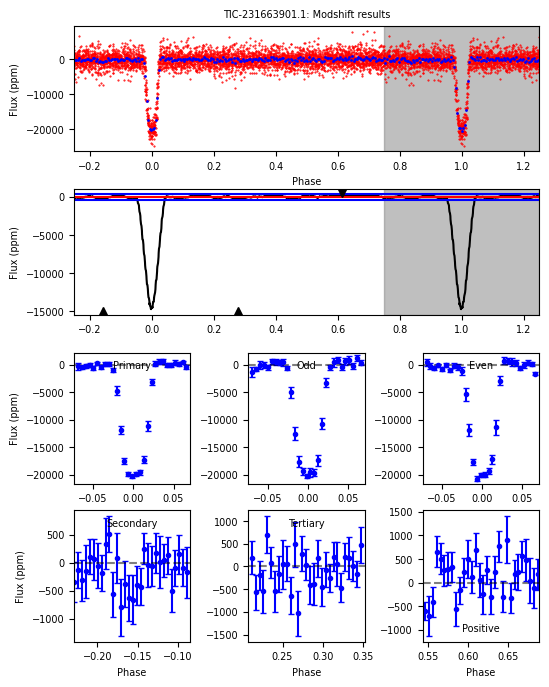

In [7]:
plot_modshift(tlc, save_fig=False)

The second vetting report is a "summary page" meant to put standard views useful for exoplanet vetting on the same page, namely:
- the raw and detrended light curves
- the full phase diagram and a close-up of the transit
- odd and even transits
- strongest detected secondary event
- a close-up of the phase diagram at half the orbit (the location of secondary eclipses in the case of circular orbits)
- individual transit events
- information about the planet and star

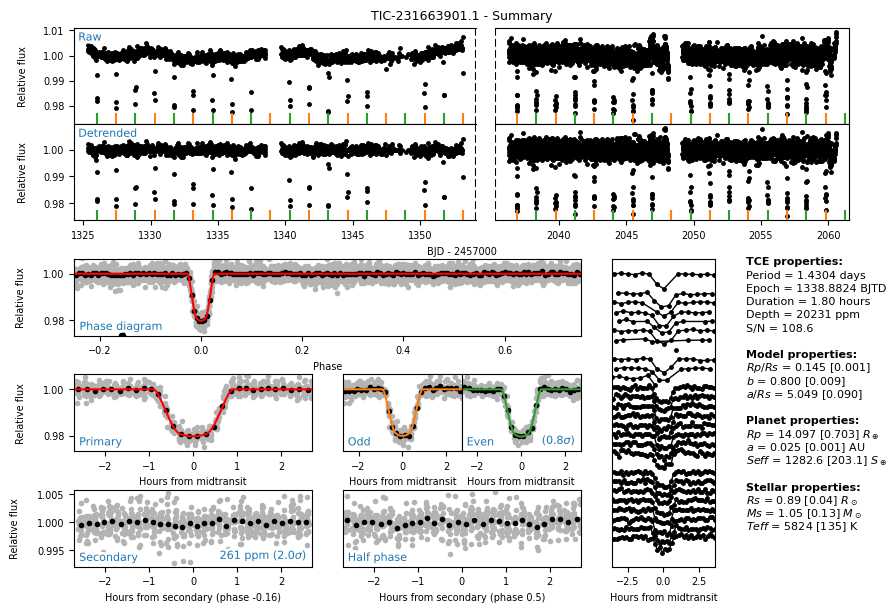

In [8]:
plot_summary(tlc, star, save_fig=False)